# Sensitivity Tests Output

Working with the output from HiPerGator/main.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from tqdm import tqdm

from pathlib import Path

import photoeccentric as ph

from pathlib import Path


plt.rcParams['figure.dpi'] = 150

In [2]:
def rmdir(directory):
    directory = Path(directory)
    for item in directory.iterdir():
        if item.is_dir():
            rmdir(item)
        else:
            item.unlink()


In [3]:
#distpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270_noTdur/"
distpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270_withTdur/"

In [21]:
def find_empty_dirs(root_dir=distpath_uniform):
    for dirpath, dirs, files in os.walk(root_dir):
        if not files:
            yield dirpath
        elif len(files) != 7:
            yield dirpath

print(list(find_empty_dirs())[:])

['/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270_withTdur/', '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270_withTdur/e_0.7459895489252937_w_-64.47556912055313']


In [26]:
truee = []
truew = []
edist_uniform = []
i = 0

for subdir, dirs, files in os.walk(distpath_uniform):
    try:
        trueparams = subdir.split("/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270_withTdur/e_",1)[1]
        truee.append(float(trueparams.split('_w_')[0]))
        truew.append(float(trueparams.split('_w_')[1]))
    except IndexError:
        continue
    for file in files:
        if 'distributions' in file:
            i+=1
            distpath = os.path.join(subdir, file)
            edist_uniform.append(np.genfromtxt(distpath, delimiter=','))
    
truee = np.array(truee)
truew = np.array(truew)
edist_uniform = np.array(edist_uniform)

In [30]:
fite = []
for i in range(len(edist_uniform)):
    fite.append(ph.mode(edist_uniform[i][:,0]))
fite = np.array(fite)

fitw = []
for i in range(len(edist_uniform)):
    fitw.append(ph.mode(edist_uniform[i][:,1]))
fitw = np.array(fitw)

fitg = []
for i in range(len(edist_uniform)):
    fitg.append(ph.mode(edist_uniform[i][:,2]))
fitg = np.array(fitg)

fitT14 = []
for i in range(len(edist_uniform)):
    fitT14.append(ph.mode(edist_uniform[i][:,3]))
fitT14 = np.array(fitT14)

fitT23 = []
for i in range(len(edist_uniform)):
    fitT23.append(ph.mode(edist_uniform[i][:,4]))
fitT23 = np.array(fitT23)

In [33]:
len(fitT23)

309

In [34]:
len(edist_uniform)

309

In [35]:
e_errors = np.abs(truee-fite)

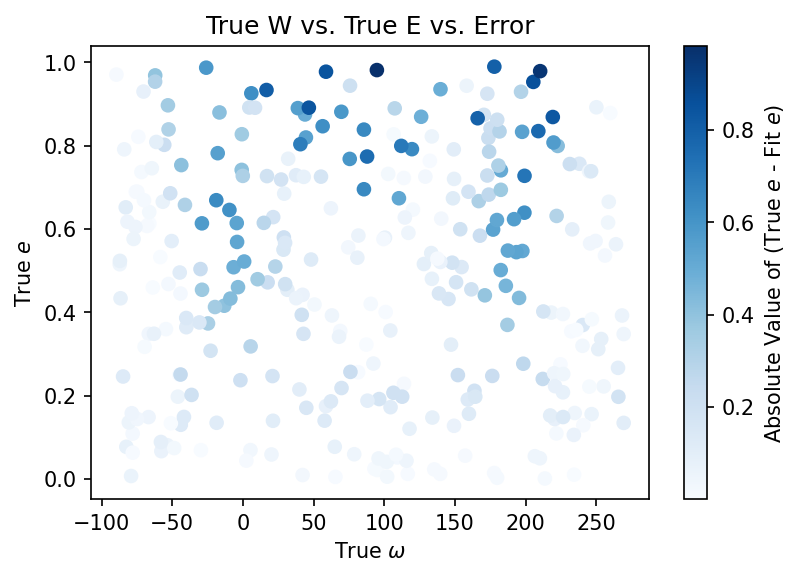

In [36]:
plt.scatter(truew, truee, c=e_errors, cmap='Blues')
plt.ylabel('True $e$')
plt.xlabel('True $\omega$')
plt.title('True W vs. True E vs. Error')

plt.clim(min(abs(e_errors)), max(abs(e_errors)))
plt.colorbar(label='Absolute Value of (True $e$ - Fit $e$)')
plt.savefig('nodiv_scatter_eerror_new.png')

In [37]:
def deltallike(g, gerr, truee, truew, fite, fitw):
    
    model_fit = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2_fit = gerr ** 2
    loglike_fit = -0.5 * np.sum((g - model_fit) ** 2 / sigma2_fit + np.log(sigma2_fit))
    
    
    model_true = (1+truee*np.sin(truew*(np.pi/180.)))/np.sqrt(1-truee**2)
    sigma2_true = gerr ** 2
    loglike_true = -0.5 * np.sum((g - model_true) ** 2 / sigma2_true + np.log(sigma2_true))
    
    llike = np.abs(loglike_fit-loglike_true)
    return llike



llike = []

for i in range(len(truee)):

    g = ph.mode(edist_uniform[i][:,2])
    e = ph.mode(edist_uniform[i][:,0])
    w = ph.mode(edist_uniform[i][:,1])
    
    gerr = np.nanstd(edist_uniform[i][:,2])
    
    llike.append(deltallike(g, gerr, truee[i], truew[i], e, w))
    
    
llike = np.array(llike)

In [38]:
like = np.e**llike

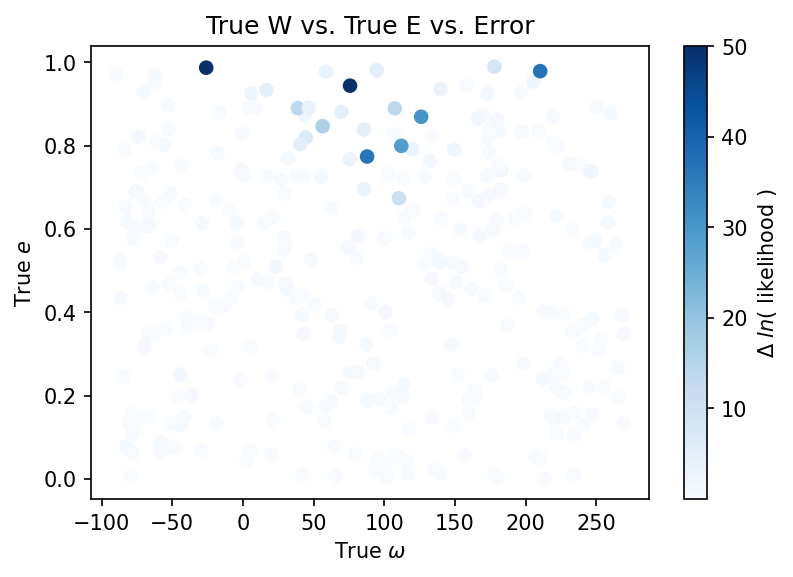

In [39]:
plt.scatter(truew, truee, c=llike, cmap='Blues')
#plt.scatter(truew, truee, c=like, cmap='cool', norm=matplotlib.colors.LogNorm())
plt.clim(vmax=50)
plt.ylabel('True $e$')
plt.xlabel('True $\omega$')
plt.title('True W vs. True E vs. Error')

plt.colorbar(label='$\Delta$ $ln($ likelihood $)$')
plt.savefig('nodiv_scatter_eerror_llike_new.png')

In [42]:
true_planet_params = [4.83809469, 0.036066, 33.79155851141583, 89.98]

period, rprs, ars, inc = true_planet_params

In [47]:
true_T14 = float(ph.get_T14([period], [rprs], [ars], [inc]))
true_T23 = float(ph.get_T23([period], [rprs], [ars], [inc]))

In [60]:
T14error = (fitT14-true_T14)/true_T14
T23error = (fitT23-true_T23)/true_T23

In [86]:
T14error[0]

0.7960076227409512

In [87]:
T23error[0]

0.7769775122997545

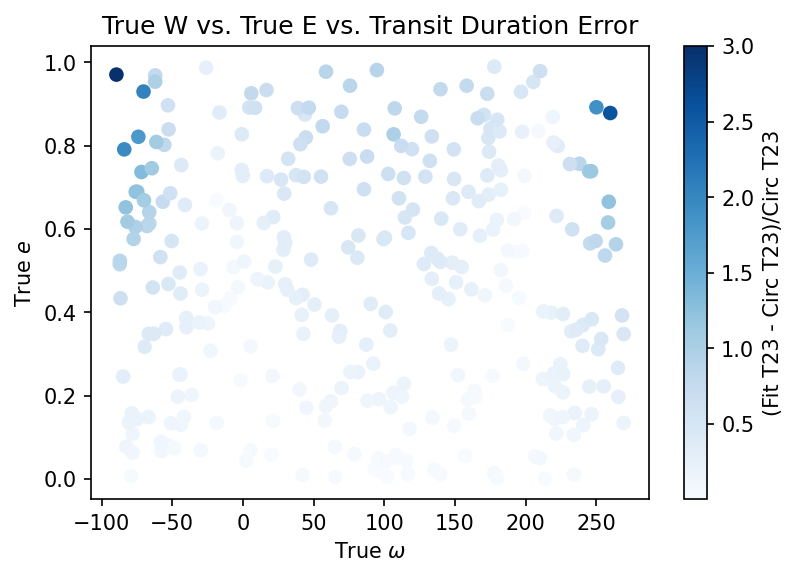

In [90]:
plt.scatter(truew, truee, c=abs(T23error), cmap='Blues')
#plt.scatter(truew, truee, c=like, cmap='cool', norm=matplotlib.colors.LogNorm()
plt.clim(vmax=3)
plt.ylabel('True $e$')
plt.xlabel('True $\omega$')
plt.title('True W vs. True E vs. Transit Duration Error')

plt.colorbar(label='(Fit T23 - Circ T23)/Circ T23')
plt.savefig('scatter_T23error.png')

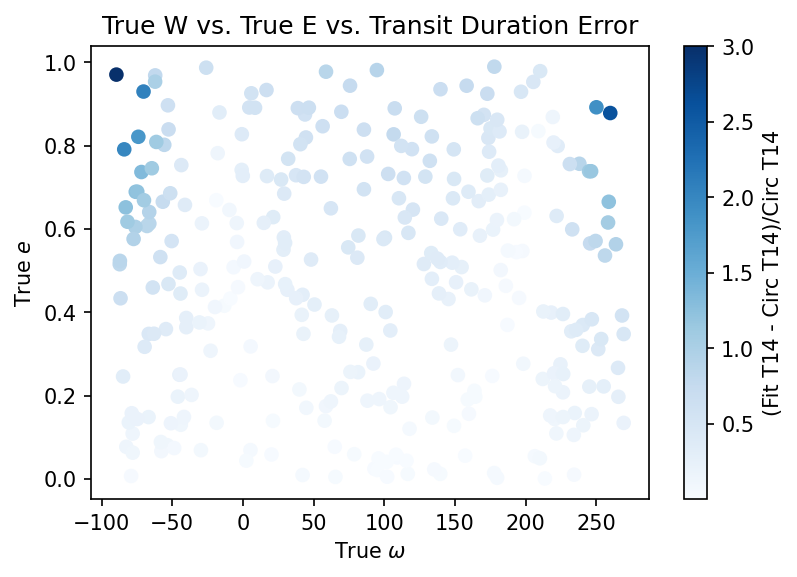

In [91]:
plt.scatter(truew, truee, c=abs(T14error), cmap='Blues')
#plt.scatter(truew, truee, c=like, cmap='cool', norm=matplotlib.colors.LogNorm()
plt.clim(vmax=3)
plt.ylabel('True $e$')
plt.xlabel('True $\omega$')
plt.title('True W vs. True E vs. Transit Duration Error')

plt.colorbar(label='(Fit T14 - Circ T14)/Circ T14')
plt.savefig('scatter_T14error.png')

# Heatmap

100%|██████████| 309/309 [00:00<00:00, 37324.04it/s]
<ipython-input-40-46ba5d10d625>:142: RuntimeWarning: invalid value encountered in double_scalars
  counts.T[i][j] = counts.T[i][j]/counts_tot.T[i][j]


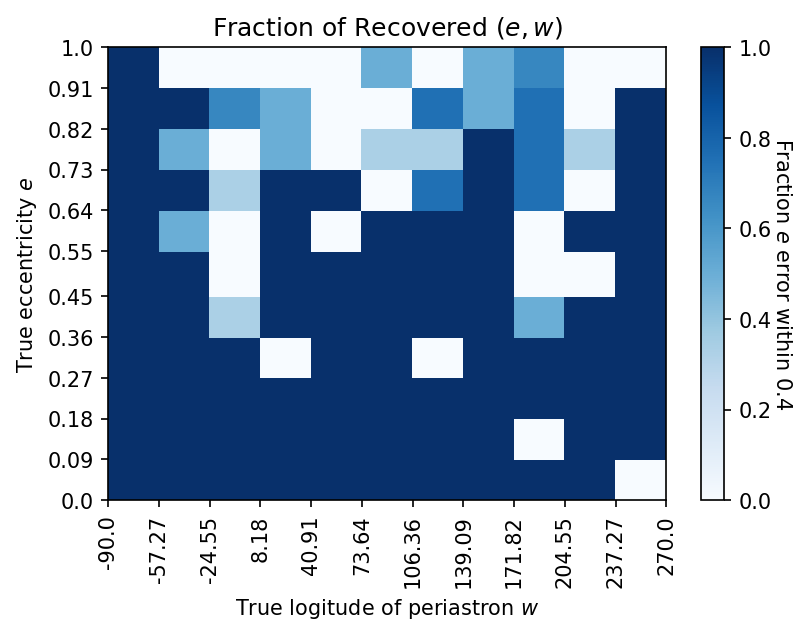

In [40]:
def heatmap_bins(e_min, e_max, nebins, w_min, w_max, nwbins, loge=False):
    """
    Gets bin edges for detection efficiency heatmap.
    
    Parameters
    ----------
    e_min: float
        Minimum e in sample
    period_max: float
        Maximum period in sample
    nperbins: int
        Number of period bins in heatmap
    rprs_min: float
        Minimum Rp/Rs in sample (or radius)
    rprs_max: float
        Maximum Rp/Rs in sample (or radius)
    nradbins: int
        Number of radius bins in heatmap
    logper: boolean, default True
        Log x (period)-axis?

    Returns
    -------
    per_segments: np.array
        Array of x-axis (period) bin edges
    rprs_segments: np.array
        Array of y-axis (radius) bin edges
    
    """

    if loge==True:

        natural_val = np.linspace(e_min, np.log10(e_max), num=nebins, endpoint=True).round(decimals=2)
        e_segments = np.array([10**x for x in natural_val]).round(decimals=2)
        
    if loge==False:
        
        e_segments = np.linspace(e_min, e_max, num=nebins, endpoint=True).round(decimals=2)

    
    w_segments = np.linspace(w_min, w_max, num=nwbins).round(decimals=2)
    
    return e_segments, w_segments


# Getting bin edges
e_segments, w_segments = heatmap_bins(0.0, 1.0, 12, -90., 270., 12, loge=False)

def is_recovered(error, e, fe, w, fw, e_segments, w_segments):#true (injected) period, L-M fitting period, true rp/rs, L-M fitting rp/rs
    
    """
    Determines whether a planet is recovered.
    
    ** Note **
    The first if-statement can be changed to reflect the conditions for planet recovery.
    
    ** Note **
    r_list, recovered_period, and recovered_rprs must be defined outside of this function (see cell below)
    
    
    Parameters
    ----------
    period: float
        True (known) period of simulated planet
    fitper: float
        Fit (recovered) period of simulated planet
    rprs: float
        True (known) Rp/Rs of simulated planet
    fitrprs: float
        Fit (recovered) Rp/Rs of simulated planet
    per_segments: np.array
        Period bin edges
    rprs_segments: np.array
        Radius bin edges
        
    Returns
    -------
    None
    
    
    """
    if error < 0.4:
    #You can define your own definition of "recovered" here.
    
        recovered = True
        
        recovered_es.append(e)
        recovered_ws.append(w)
        
        for e_i in range(len(e_segments)-1):
            for w_i in range(len(w_segments)-1):
                if e_segments[e_i] < e < e_segments[e_i+1]:
                    if w_segments[w_i] < w < w_segments[w_i+1]:
                        r_list[w_i][e_i] += 1
                        
    else:
        
        recovered = False


# Define lists to save for heatmap
r_list = np.zeros((len(e_segments), len(w_segments)))
recovered_es = []
recovered_ws = []


for i in tqdm(range(len(truee))):
    is_recovered(e_errors[i], truee[i], fite[i], truew[i], fitw[i], e_segments, w_segments)

def plot(recovered_es, recovered_ws, true_es, true_ws, filename='heatmaps_uniform/e_w_heatmap.png', xlog=False):
    
    """
    Plots + saves detection efficiency heatmap
    
    Parameters
    ----------
    recovered_period: np.array
        Array of "fit" es
    recovered_rprs: np.array
        Array of "fit" ws
    true_periods: np.array
        Array of true (simulated) periods
    true_rprs: np.array
        Array of true (simulated) radii
    filename: str, default 'heatmap.png'
        Directory + filename to save heatmap
    xlog: boolean, default True
        Log x-axis? Must match logper argument in heatmap_bins()
        
    Returns
    -------
    fig: matplotlib.figure.Figure object
        Heatmap
    
    """
    
    counts, _, _ = np.histogram2d(recovered_ws, recovered_es, bins=(w_segments, e_segments))
    counts_tot, _, _ = np.histogram2d(true_ws, true_es, bins=(w_segments, e_segments))

    for i in range(len(counts.T)):
        for j in range(len(counts.T[i])):
            counts.T[i][j] = counts.T[i][j]/counts_tot.T[i][j]
            if np.isnan(counts.T[i][j]):
                counts.T[i][j] = 0

    matplotlib.rcParams['xtick.minor.size'] = 0
    matplotlib.rcParams['xtick.minor.width'] = 0

    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(w_segments, e_segments, counts.T, cmap='Blues')
    
    if xlog==True:
        ax.set_xscale('log')

    ax.xaxis.set_ticks(w_segments)
    ax.xaxis.set_ticklabels(w_segments, fontsize=10, rotation='vertical')

    ax.yaxis.set_ticks(e_segments)
    ax.yaxis.set_ticklabels(e_segments)

    ax.set_title('Fraction of Recovered $(e,w)$')
    ax.set_ylabel('True eccentricity $e$')
    ax.set_xlabel('True logitude of periastron $w$')


    cbar = plt.colorbar(heatmap)
    heatmap.set_clim(0.0, 1.0)
    cbar.set_label('Fraction $e$ error within 0.4', rotation=270, labelpad=10)


    plt.savefig(filename)
    plt.show()
    
    return fig


heatmap = plot(recovered_es, recovered_ws, truee, truew, xlog=False)


In [41]:
H, xedges, yedges = np.histogram2d(truew, truee, bins = [w_segments, e_segments], weights = llike)
H_counts, xedges, yedges = np.histogram2d(truew, truee, bins = [w_segments, e_segments]) 
H = H/H_counts

<ipython-input-41-0ae99cd2ff74>:3: RuntimeWarning: invalid value encountered in true_divide
  H = H/H_counts


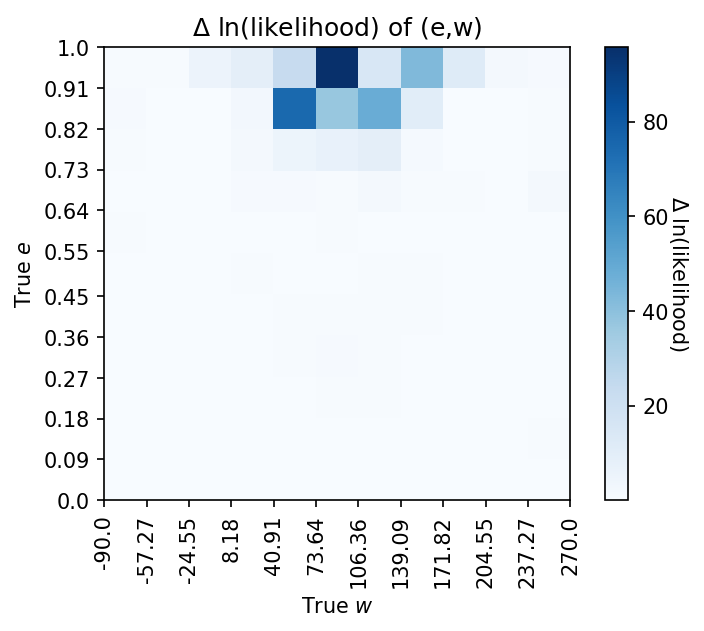

In [248]:
fig, ax = plt.subplots()
heatmap = ax.imshow(H.T, origin='lower',  cmap='Blues', extent = [-90, 270, 0, 1], aspect=350)
#norm=matplotlib.colors.LogNorm()



ax.xaxis.set_ticks(w_segments)
ax.xaxis.set_ticklabels(w_segments, fontsize=10, rotation='vertical')

ax.yaxis.set_ticks(e_segments)
ax.yaxis.set_ticklabels(e_segments)

ax.set_title('$\Delta$ ln(likelihood) of (e,w)')
ax.set_ylabel('True $e$')
ax.set_xlabel('True $w$')


cbar = plt.colorbar(heatmap)

cbar.set_label('$\Delta$ ln(likelihood)', rotation=270, labelpad=10)

plt.savefig('heatmaps_uniform/deltallike_heatmap.png')